In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import *
from dysts_simulation import Rossler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from tqdm.auto import tqdm
import warnings

from demo_utils import compute_lyaps

warnings.filterwarnings(action='ignore', message='Mean of empty slice')

# DeLASE Tutorial

Welcome to the DeLASE tutorial! In this tutorial, we'll go through an example of using DeLASE to analyze a chaotic dynamical system. We'll be using the Rossler system, a simple chaotic dynamical system.

## Simulating the Rossler System

In this notebook, we'll begin by simulating the data we'll be analzying. The data is going to come from the Rossler system, a simple chaotic dynamical system. The Rossler system is defined by the following equations:

$$ \dot{x} = -y - z $$
$$ \dot{y} = x + ay $$
$$ \dot{z} = b + z(x - c) $$

Where $a$, $b$, and $c$ are constants. The Rossler system is chaotic for certain values of these constants, and we'll be using the following values: $b = 0.2$, $c = 5.7$, and either $a = 0.02$ or $a = 0.28$. If $a = 0.02$, the system is near the boundary of instability with a strong oscillatory component.  If $a = 0.28$, the system is well within the chaotic regime.

To simulate the Rossler system, I'm using an adapted version of this [`dysts`](https://github.com/williamgilpin/dysts) package by William Gilpin. This package is designed to simulate chaotic dynamical systems in a standardized way, I highly recommend checking it out!

In [3]:
# --------------------------
# SIMULATION PARAMETERS
# --------------------------

# set the number of trajectories to simulate
num_trajs = 3
# num_trajs = 10

# the number of periods to include in the data. Periods were computed as the inverse of the dominant frequency of the system, with a = 0.2.
# n_periods = 12
n_periods = 15

# the number of points per period
pts_per_period = 500
# pts_per_period = 500

# the list of parameters to simulate
param_list = [0.02, 0.28]
param_name = "a"

# how much to offset trajectories by for each subsequent simulation
traj_offset_sd = 1e-3

# set random state for consistency
random_state = 42


# --------------------------
# SIMULATION
# --------------------------

T = n_periods*pts_per_period

# remove the transient of 1/10 of the total simulation time
transient = int(0.1*T)
train_window = int(0.6*T)
test_window = int(0.3*T)

trajectories = {}

eqs = {}
for param in param_list:
    params = dict(
        a=param,
        b=0.1,
        c=5.7
    )
    eq = Rossler(**params, random_state=random_state)
    eqs[param] = eq
    trajectories[param] = eq.make_trajectory(n_periods=n_periods, num_ics=num_trajs, pts_per_period=pts_per_period, traj_offset_sd=traj_offset_sd, verbose=True)
    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# compute the time step of simulation, dt, as the period of the system divided by the number of points per period
dt = eq.period/pts_per_period
t_inds = np.arange(n_periods*pts_per_period)
t_eval = t_inds*dt

# set the indices for the training and testing windows
# transient is the first 10% of the data
# train_window is the next 60% of the data
# test_window is the final 30% of the data
train_inds = np.arange(transient, transient + train_window)
test_inds = np.arange(transient + train_window, transient + train_window + test_window)

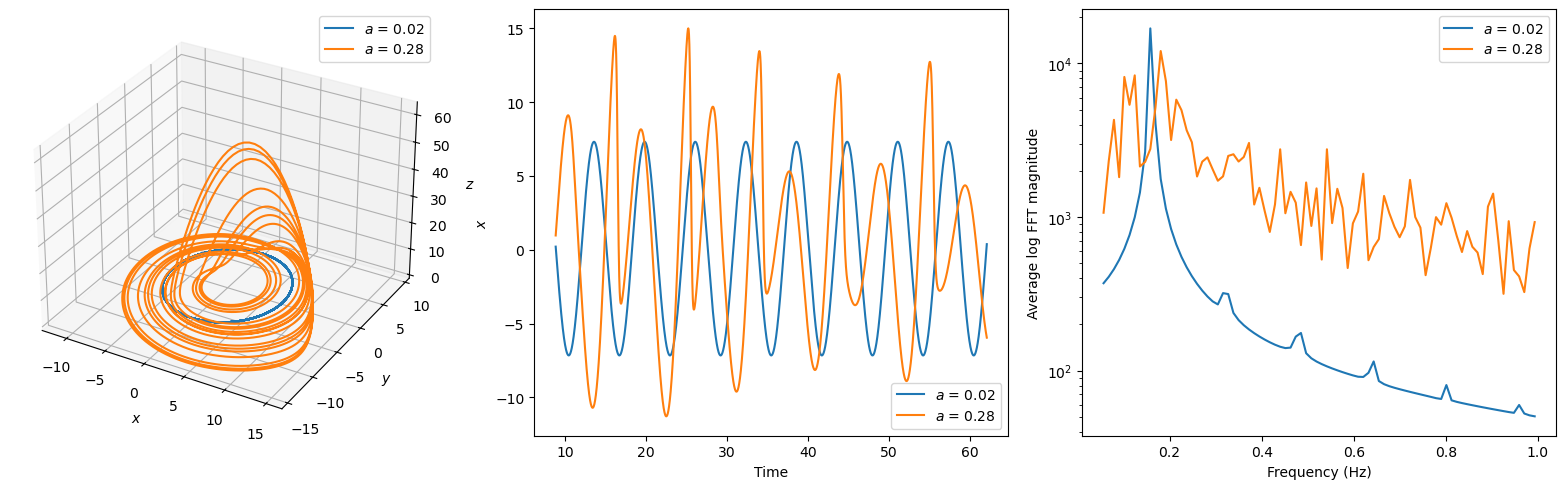

In [5]:
# --------------------------
# PLOTTING THE ROSSLER SYSTEM
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
traj_num = -1
axs[0].remove()
axs[0] = fig.add_subplot(1, 3, 1, projection='3d')
for param, x in trajectories.items():
    ax = axs[0]
    ax.plot(x[traj_num, :, 0], x[traj_num, :, 1], x[traj_num, :, 2], label=f"${param_name}$ = {param}")
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.set_zlabel("$z$")
    ax = axs[1]
    ax.plot(t_eval[train_inds], x[traj_num, train_inds, 0], label=f"${param_name}$ = {param}")
    ax.set_xlabel("Time")
    ax.set_ylabel("$x$")
axs[0].legend()
axs[1].legend()

# plot the power spectrum of the trajectories
max_freq = 1
min_freq = 0.05
log = True
norm = False
ax = axs[2]
for param, x in trajectories.items():
    if norm:
        x = (x - x.mean())/x.std()
    fft_mag = np.abs(np.fft.rfft(x.transpose(0, 2, 1).reshape(-1, x.shape[1]))).mean(axis=0)
    freqs = np.fft.rfftfreq(x.shape[1], d=dt)
    freq_inds = (freqs >= min_freq) & (freqs <= max_freq)
    ax.plot(freqs[freq_inds], fft_mag[freq_inds], label=fr"${param_name}$ = {param}")
ax.set_xlabel("Frequency (Hz)")

ax.legend()
if log:
    ax.set_yscale("log")
    ax.set_ylabel("Average log FFT magnitude")
else:
    ax.set_ylabel("Average FFT magnitude")

plt.tight_layout()
plt.show()

In [6]:
# --------------------------
# COMPUTE LYAPUNOV EXPONENTS (ground truth stability)
# --------------------------

jacobians = {}

time_inds_jac = t_inds

for param, x in trajectories.items():
    eq = eqs[param]
    jacs = np.zeros((num_trajs, len(time_inds_jac), 3, 3))
    for num_traj in range(num_trajs):
        jacs[num_traj] = np.array([eq.jac(x[num_traj, t], t*dt) for t in time_inds_jac])
    jacobians[param] = jacs

lyaps = {}
for param, jacobian_mats in tqdm(jacobians.items()):
    lyap_vals = np.zeros((num_trajs, 3))
    for num_traj in range(num_trajs):
        lyap_vals[num_traj] = compute_lyaps(np.eye(3) + dt*jacobian_mats[num_traj], dt=dt)
    lyaps[param] = lyap_vals

max_lyap_means = [lyaps[param][:, 0].mean() for param in param_list]
max_lyap_ses = [lyaps[param][:, 0].std()/np.sqrt(lyaps[param].shape[0]) for param in param_list]
labels = [fr"${param_name}$ = {param}" for param in param_list]
colors = ['skyblue' if param == np.max(param_list) else 'salmon' for param in param_list]

  0%|          | 0/2 [00:00<?, ?it/s]

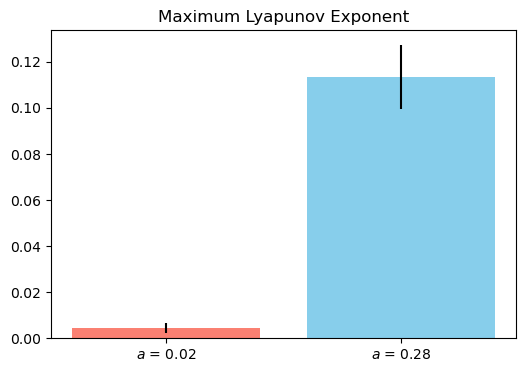

In [7]:
plt.figure(figsize=(6, 4))
plt.bar(labels, max_lyap_means, yerr=max_lyap_ses, color=colors)

plt.title('Maximum Lyapunov Exponent')

plt.show()

As you can see, the system is chaotic for $a = 0.28$ and stable for $a = 0.02$. We'll see if we can reproduce this ordering with DeLASE. Importantly, we'll see if we can do so while partially observing this system. We also will make no assumptions about the necessary number of delays or rank. Finally, we'll be doing this with linear models, despite the nonlinearity of the Rossler system.

## Stability Analysis (If you have data already, your analysis starts here!)

### Grid Searching

An important part of the DeLASE algorithm is the grid search over HAVOK hyperparameters. This is where we determine which hyperparameters (in this case `n_delays` and `rank`) are best for our data. The parameter `n_delays` controls the number of delays used to construct the model, and `rank` controls the rank of the model. A third hyperparameter, `delay_interval`, can also be tuned, but here (as in the original paper) we'll fix it to 1. The parameter `delay_interval` controls the spacing of the delays.

In [8]:
# --------------------------
# GRID SEARCH PARAMETERS
# --------------------------

# choose the number of delays to consider
n_delays_vals = np.arange(1, 12)
# choose the rank of the model to consider
rank_vals = np.arange(1, 12)
# choose the delay intervals to consider
delay_interval_vals = [1]

# choose whether to compute stability
compute_stability = True
# set the maximum frequency of characteristic roots to the nyquist frequency
max_freq = (1/(dt))/2
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# choose whether to show progress bar
verbose = True

# indices_to_observe = np.arange(3)
indices_to_observe = [0]

hyperparameter_grid = dict(
    n_delays_vals=n_delays_vals,
    rank_vals=rank_vals,
    delay_interval_vals=delay_interval_vals
)

grid_search_kwargs = dict(
    dt=dt,
    compute_stability=compute_stability,
    max_freq=max_freq,
    device=device,
    verbose=verbose
)


Recall that `trajectories` is a dictionary, where each key is a condition, and each value is an array of trajectories. That is, in the below code, `data_sets` is an array of trajectories for a single condition. The shape of `data_sets` is `(num_trajs, num_pts, num_vars)`.

For each trajectory, it's important to split the data into a training and testing set. Here, we're using the first 60% of the data as a training set, and the final 30% as a testing set. The test prediction error is used to determine the best hyperparameters.

Note also that we've set the parameter `compute_stability` to `True`, so that the stability of the system is also computed for each hyperparameter combination. This is useful for testing, but slows down the grid search. So you may not want to do this for _every_ grid search.

In [9]:
grid_search_results = {}
for param, data_sets in trajectories.items():
    x_train = data_sets[..., train_inds, :]
    x_test = data_sets[..., test_inds, :]

    x_train = x_train[..., indices_to_observe]
    x_test = x_test[..., indices_to_observe]

    grid_search_results[param] = perform_grid_search(x_train, x_test, **grid_search_kwargs, **hyperparameter_grid)

Grid search:   0%|          | 0/363 [00:00<?, ?it/s]

Grid search:   0%|          | 0/363 [00:00<?, ?it/s]

Here, the parameters we're looping over are the values of $a$ in the Rossler system. In your data, **this corresponds to different conditions you want to compare**. The output of `perform_grid_search` is a list. Each element of the list is a dataframe with the results of the grid search for a single data set (in this case, a single trajectory). In your data, each trajectory corresponds to a different window of time.

Thus grid_search_results is a dictionary, where each key is a condition, and each value is a list of dataframes corresponding to the results of the grid search for each trajectory.

We can now compile the results across the trajectories, and hyperparameters, to get a sense of which hyperparameters are best.

For this we're using the function `get_results_matrix`.

In [10]:
aic_results = {param: get_results_matrix(grid_search_results[param], 'aic', **hyperparameter_grid) for param in param_list}
mase_results = {param: get_results_matrix(grid_search_results[param], 'mase', **hyperparameter_grid) for param in param_list}

Each value of `aic_results` and `mase_results` is an array, with the first dimension being the number of trajectories, the second dimension being the number of values for `n_delays`, the third dimension being the number of values for `rank`, and the fourth dimension being the number of values for `delay_interval`. Each key of `aic_results` and `mase_results` is a condition, and the value is the array of results for that condition.

Not here that when computing the optimal hyperparameters, we're averaging across conditions! This is because we want the hyperparameters we choose to capture the dynamics of the system across conditions. Also, since the hyperparameters will affect the absolute values of the stability estimates, in comparing stability between conditions, it's important to ensure that the hyperparameters chosen were consistent.

In [11]:
# get the optimal hyperparameters
optimal_hyperparameters = get_optimal_hyperparameters(aic_results, **hyperparameter_grid)
optimal_n_delays = optimal_hyperparameters['n_delays']
optimal_rank = optimal_hyperparameters['rank']
optimal_delay_interval = optimal_hyperparameters['delay_interval']
optimal_idx = optimal_hyperparameters['idx']

### Plotting stability

Now that we've found the optimal hyperparameters, we can plot the results. Since we didn't use a grid search over the delay interval, we'll just plot the results for `delay_interval` = 1. Not here that we're plotting both the average AIC and the average MASE (across parameters and trajectories). To pick hyperparameters, we typically look for the lowest AIC, and then check that the MASE is low. The AIC penalizes models with more parameters, so it's a good way to avoid overfitting. The MASE is a measure of prediction error, so it's a good way to avoid underfitting.

AIC stands for Akaike Information Criterion. It's a measure of model complexity and prediction error. The lower the AIC, the better the model.

MASE stands for Mean Absolute Scaled Error. It's a normalized measure of prediction error, where the normalization is the "persistence baseline". The persistence baseline is a naive model that predicts that each time step will be the same as the last time step. Thus if the MASE is less than 1, the model is outperforming the persistence baseline. If the MASE is greater than 1, the model is performing worse than the persistence baseline. Typically, we want the MASE to be less than 1, to ensure we're capturing some of the dynamics of the system.


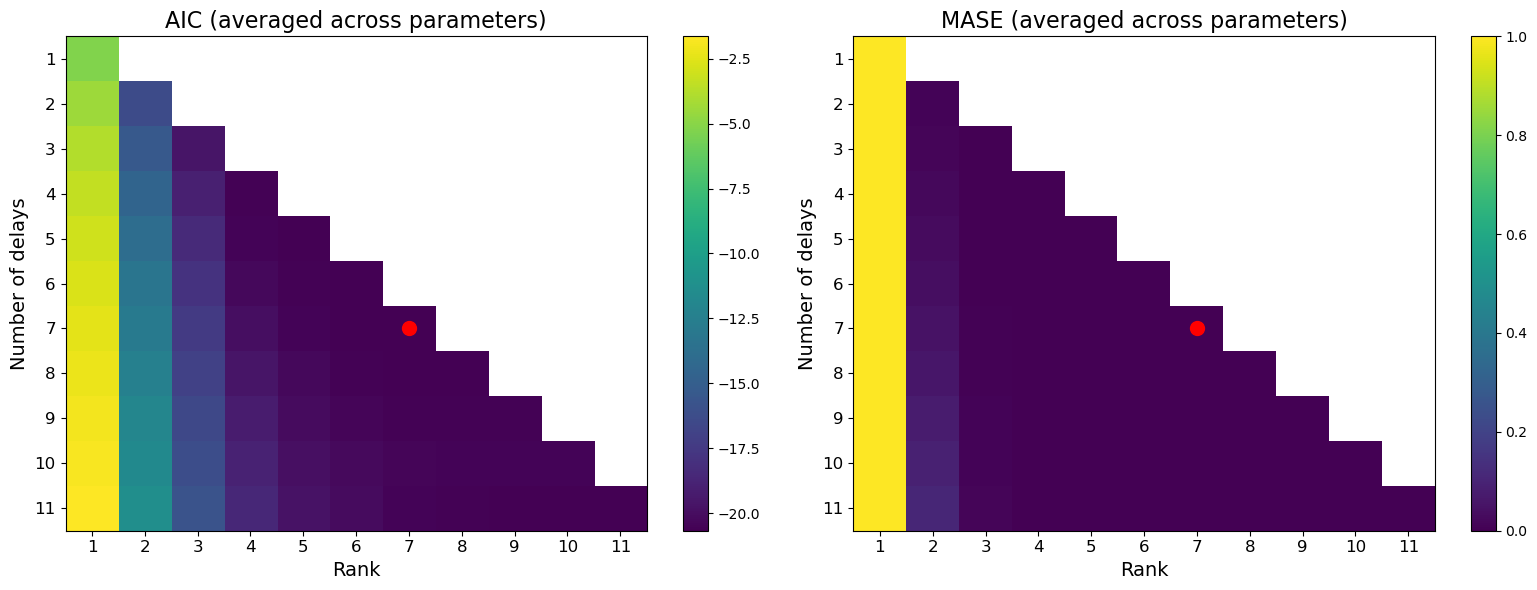

Optimal hyperparameters (based on average AIC):
  n_delays = 7, rank = 7, delay_interval = 1


In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Average AIC across parameters and trajectories
aic_mean = np.nanmean(np.concatenate(list(aic_results.values()), axis=0), axis=(0,))
ax = axs[0]
im = ax.imshow(aic_mean[:, :, 0], aspect='auto')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)
ax.set_title('AIC (averaged across parameters)', fontsize=16)
ax.set_xlabel('Rank', fontsize=14)
ax.set_ylabel('Number of delays', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Average MASE across parameters and trajectories
mase_mean = np.nanmean(np.concatenate(list(mase_results.values()), axis=0), axis=(0,))
ax = axs[1]
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
im = ax.imshow(mase_mean[:, :, 0], aspect='auto', norm=norm)
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)
ax.set_title('MASE (averaged across parameters)', fontsize=16)
ax.set_xlabel('Rank', fontsize=14)
ax.set_ylabel('Number of delays', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# Find and plot the optimal hyperparameters
axs[0].scatter(optimal_idx[1], optimal_idx[0], c='red', s=100, marker='o')
axs[1].scatter(optimal_idx[1], optimal_idx[0], c='red', s=100, marker='o')

plt.tight_layout()
plt.show()

# Print the optimal hyperparameters
print(f"Optimal hyperparameters (based on average AIC):")
print(f"  n_delays = {optimal_n_delays}, rank = {optimal_rank}, delay_interval = {optimal_delay_interval}")

We've now found the hyperparameters that minimize the AIC, and it seems like the MASE is low as well, indicating that we're not overfitting or underfitting. We can now plot the stability of the system for each hyperparameter setting. Here, we'll plot the top 10% of the stability spectrum. We've found that 10% is a good choice in most cases, but it's always important to check the stability of the system for other portions of the characteristic root spectrum.

A few notes:
- Keep in mind that the stability is determined by the top characteristic roots, so the results may shift when considering the full computed spectrum.
- DeLASE will only compute as many characteristic roots as there are dimensions in the delay embedding (i.e., number of variables * number of delays). However if the rank is less than the number of dimensions, the characteristic roots beyond the top `rank` will be spurious, so keep that in mind when interpreting the results.
- In this case, the optimal number of delays is 10, and we only observed 1 variable, so we only computed 10 characteristic roots. And thus, the stability results, based on the top 10% of the spectrum, will only take on root per trajectory. This might lead to a bit of noise in the stability results, but it's still informative.

In [13]:
top_percent = 0.1
stability_results = {param: get_results_matrix(grid_search_results[param], 'stability', n_delays_vals, rank_vals, delay_interval_vals, top_percent=top_percent) for param in param_list}

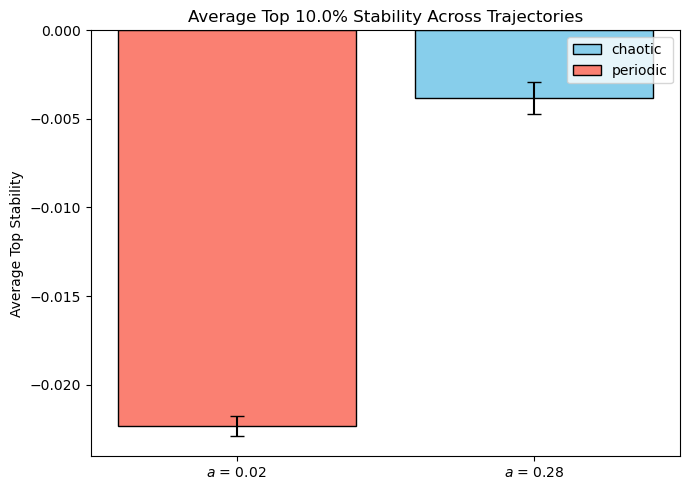

In [18]:
avg_stabilities = []
std_errors = []

for param_ind, param in enumerate(param_list):
    optimal_stabilities = stability_results[param][:,
                                        optimal_idx[0],
                                        optimal_idx[1],
                                        optimal_idx[2]]
    avg_stabilities.append(np.mean(optimal_stabilities))
    std_errors.append(np.std(optimal_stabilities) / np.sqrt(len(optimal_stabilities)))

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))
colors = ['skyblue' if param == np.max(param_list) else 'salmon' for param in param_list]

ax.bar(np.arange(len(param_list)), avg_stabilities, yerr=std_errors, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(param_list)))
ax.set_xticklabels([fr"${param_name}$ = {param}" for param in param_list])
ax.set_ylabel("Average Top Stability")
ax.set_title(f"Average Top {top_percent*100}% Stability Across Trajectories")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'periodic'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
ax.legend(handles=legend_handles, loc='upper right')

plt.tight_layout()
plt.show()


### Validating results across hyperparameters

We've now confirmed that, based on DeLASE analysis, the Rossler system is more unstable for $a = 0.28$ than for $a = 0.02$.

To have more confidence in the results, we can plot the stability difference vs the mean AIC. If the stability difference is large and positive, it means that the system is more unstable for the chaotic Rossler system. If the stability difference is large and negative, it means that the system is more unstable for the periodic Rossler system. If the stability difference is close to zero, it means that the systems are similarly unstable according to DeLASE.

We expect that models that capture the data better will have better stability estimates. Thus, we expect that for better models, (lower AIC) the stability difference will be larger and positive. If there are stability differences that are negative, we expect that these will correspond to worse models (higher AIC). Thus we plot the stability difference vs the mean AIC, and compute a correlation coefficient to confirm the relationship.

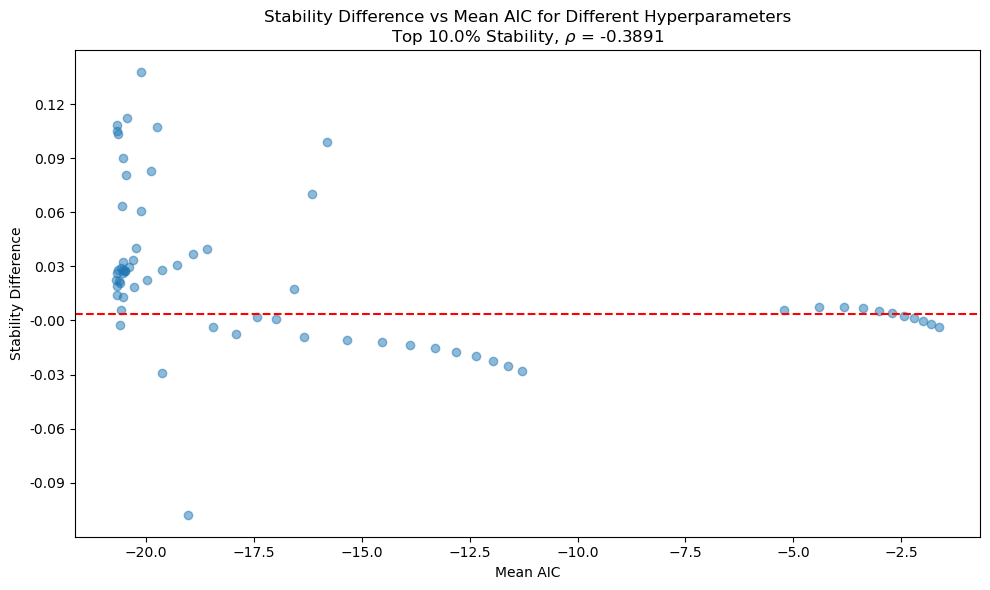

In [19]:
mean_stability = [np.nanmean(stability_results[param], axis=(0,)) for param in param_list]  # Average across hyperparameters and trajectories for each param
mean_aic = np.nanmean(np.concatenate([aic_results[param] for param in param_list], axis=0), axis=(0,))  # Average across params and trajectories

# Compute stability difference
stability_diff = mean_stability[1] - mean_stability[0]  # Assuming param_list has 2 elements

# Flatten the arrays for plotting
x_vals = mean_aic.flatten()
y_vals = stability_diff.flatten()

# Remove NaN values
mask = ~np.isnan(x_vals) & ~np.isnan(y_vals)
x_vals = x_vals[mask]
y_vals = y_vals[mask]

# Add a constant to make all y values positive for log scale
constant = abs(min(y_vals)) + 1  # Adding 1 to avoid log(0)
y_vals_shifted = y_vals + constant

# Calculate correlation
correlation = np.corrcoef(x_vals, y_vals)[0, 1]

# Create the scatter plot with log scale
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(x_vals, y_vals_shifted, alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('Mean AIC')
ax.set_ylabel('Stability Difference')
ax.set_title(f'Stability Difference vs Mean AIC for Different Hyperparameters\nTop {top_percent*100}% Stability, ' + fr'$\rho$ = {correlation:.4f}')

# Add a horizontal line at y=constant (which corresponds to the original y=0)
ax.axhline(y=constant, color='r', linestyle='--')

# Adjust y-axis ticks to show original values
ylim = ax.get_ylim()
yticks = np.logspace(np.log10(ylim[0]), np.log10(ylim[1]), num=10)
yticks = yticks[(yticks > ylim[0]) & (yticks < ylim[1])]
ax.set_yticks(yticks)
ax.set_yticklabels([f'{y-constant:.2f}' for y in yticks])

# Remove minor ticks
ax.yaxis.set_minor_locator(plt.NullLocator())

plt.tight_layout()
plt.show()

As expected, the stability difference is larger and positive for better models, and the correlation coefficient is large and negative, indicating a strong relationship between the stability difference and the model quality.

It also seems as though almost all the stability differences are positive, indicating good consensus among hyperparameters. If there was not good consensus, we would have to be more careful in interpreting the results. In addition, we may want to consider a larger range of hyperparameters to ensure that we've found the optimal ones.